In [1]:
import numpy as np
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, GlobalMaxPooling2D, MaxPooling2D, Conv2D, GlobalAveragePooling2D 
from numpy import array
from keras import optimizers
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.applications.resnet50 import ResNet50
import keras.applications
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from os.path import isfile, join
from os import listdir
import os, os.path
import shutil
from random import shuffle
from shutil import copyfile
%matplotlib inline
from keras.callbacks import ModelCheckpoint
import cv2
import sys
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range=0.2,
        zoom_range=0.2,     
        rotation_range=15,
        width_shift_range=.15,
        height_shift_range=.15)
test_datagen = ImageDataGenerator(rescale=1./255)
train_path = "/home/t-judai/kaggle-link/datasets/grassknoted/asl-alphabet/asl_alphabet_train"
valid_path = "/home/t-judai/kaggle-link/datasets/grassknoted/asl-alphabet/asl_alphabet_valid"
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=24,
        class_mode='categorical',
        shuffle = True)

validation_generator = train_datagen.flow_from_directory(
        valid_path,
        target_size=(224, 224),
        batch_size=24,
        class_mode='categorical',
        shuffle = False)   

Found 60871 images belonging to 29 classes.
Found 26129 images belonging to 29 classes.


In [3]:
#base_model = keras.applications.resnet50.ResNet50(include_top=False, weights = "imagenet")
sys.path.append("/work/keras_model/")
#/home/hongzl/code/utils/keras_models
from resnet152_keras import resnet152_model
with tf.device('/device:GPU:0'):
    base_model = resnet152_model(weights_path="/work/resnet152_weights_tf.h5",classes=29)

x = base_model.output
#x = GlobalAveragePooling2D()(x) 
#x = Dense(29, activation="softmax")(x)
model = Model(base_model.input, x, name="asl_model")
model.summary()
for layer in model.layers:
    layer.trainable = True


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2 (None, 230, 230, 3)  0           data[0][0]                       
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9408        conv1_zeropadding[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
scale_conv

__________________________________________________________________________________________________
bn5c_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5c_branch2b[0][0]             
__________________________________________________________________________________________________
scale5c_branch2b (Scale)        (None, 7, 7, 512)    1024        bn5c_branch2b[0][0]              
__________________________________________________________________________________________________
res5c_branch2b_relu (Activation (None, 7, 7, 512)    0           scale5c_branch2b[0][0]           
__________________________________________________________________________________________________
res5c_branch2c (Conv2D)         (None, 7, 7, 2048)   1048576     res5c_branch2b_relu[0][0]        
__________________________________________________________________________________________________
bn5c_branch2c (BatchNormalizati (None, 7, 7, 2048)   8192        res5c_branch2c[0][0]             
__________

In [4]:
sgd = keras.optimizers.SGD(lr = 0.01,momentum=0.0, decay = 1e-4,nesterov = True)

model.compile(optimizer = sgd,
            loss="categorical_crossentropy",
            metrics=["accuracy"])
#checkpointer = ModelCheckpoint(filepath = "/home/t-judai/log_asl201.{epoch:02d}-{val_acc:.2f}.hdf5", monitor = "val_acc", verbose = 1, save_best_only = True, mode = "auto")
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2500,
        epochs=50,
        validation_data = validation_generator,
        validation_steps=1000,
        #initial_epoch=8,
        verbose = 1,
        #callbacks = [checkpointer]
        )

Epoch 1/50
2500/2500 [==============================] - 5981s 2s/step - loss: 0.1086 - acc: 0.9719 - val_loss: 0.1520 - val_acc: 0.9670
Epoch 2/50
2500/2500 [==============================] - 5957s 2s/step - loss: 0.0119 - acc: 0.9969 - val_loss: 0.1501 - val_acc: 0.9677
Epoch 3/50
2500/2500 [==============================] - 5947s 2s/step - loss: 0.0087 - acc: 0.9976 - val_loss: 0.1661 - val_acc: 0.9706
Epoch 4/50
2500/2500 [==============================] - 5944s 2s/step - loss: 0.0059 - acc: 0.9985 - val_loss: 0.1433 - val_acc: 0.9675
Epoch 5/50
2500/2500 [==============================] - 5962s 2s/step - loss: 0.0045 - acc: 0.9989 - val_loss: 0.1604 - val_acc: 0.9704
Epoch 6/50
2500/2500 [==============================] - 5969s 2s/step - loss: 0.0043 - acc: 0.9988 - val_loss: 0.1469 - val_acc: 0.9687
Epoch 7/50
2500/2500 [==============================] - 5951s 2s/step - loss: 0.0038 - acc: 0.9989 - val_loss: 0.1547 - val_acc: 0.9725
Epoch 8/50
2500/2500 [==========================

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


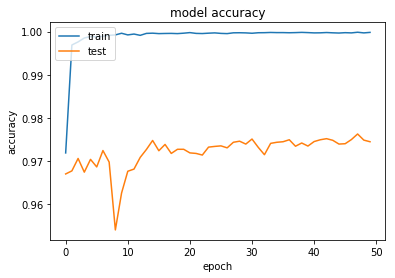

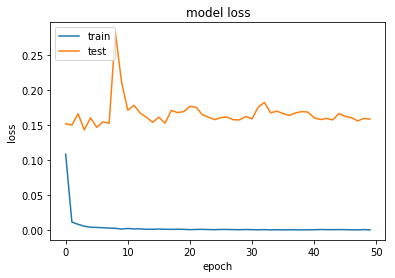

In [5]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [6]:
"""test_generator = test_datagen.flow_from_directory(
        "/home/t-judai/kaggle-link/datasets/grassknoted/asl-alphabet/asl_alphabet_test",
        target_size = (224,224),
        batch_size = 32,
        class_mode = "categorical"
        )
"""
def separateData(data_dir):
    for filename in listdir(data_dir):
        if isfile(join(data_dir, filename)):
            tokens = filename.split('.')
            if tokens[-1] == 'jpg':
                image_path = join(data_dir, filename)
                if not os.path.exists(join(data_dir, tokens[0])):
                    os.makedirs(join(data_dir, tokens[0]))
                copyfile(image_path, join(join(data_dir, tokens[0]), filename))
                os.remove(image_path)
#separateData("/home/t-judai/kaggle-link/datasets/grassknoted/asl-alphabet/asl_alphabet_test")
def plots(ims, figsize=(12,6), rows=4, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
#test_imgs, test_labels = next(test_generator)
#plots (test_imgs, titles = test_labels)

#score = model.evaluate_generator(test_generator)
#print (score)

In [7]:
"""img = "/work/kaggle-link/datasets/grassknoted/asl-alphabet/asl_alphabet_predict/space4.jpg"
file = load_img(img,target_size = (224, 224))
numpy_file = img_to_array(file)
final_file = numpy.expand_dims(numpy_file, axis = 0)
plt.imshow(np.uint8(final_file[0]))
y_prob = model.predict(final_file/255)
y_classes = y_prob.argmax(axis=-1)

print (y_prob)
print (y_classes)"""

'img = "/work/kaggle-link/datasets/grassknoted/asl-alphabet/asl_alphabet_predict/space4.jpg"\nfile = load_img(img,target_size = (224, 224))\nnumpy_file = img_to_array(file)\nfinal_file = numpy.expand_dims(numpy_file, axis = 0)\nplt.imshow(np.uint8(final_file[0]))\ny_prob = model.predict(final_file/255)\ny_classes = y_prob.argmax(axis=-1)\n\nprint (y_prob)\nprint (y_classes)'

In [8]:
#model.save("/work/7_17_18_resnet152.hdf5")

In [14]:
from sklearn import metrics

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1]= 12
    plt.rcParams["figure.figsize"] = fig_size

In [20]:
import itertools
classes = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "del", "nothing", "space"]
res = model.predict_generator(validation_generator, verbose = 1)


1089/1089 [==============================] - 739s 679ms/step


Confusion matrix, without normalization
[[898   0   0   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0 867   0   3  26   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   3   0   1   0   0   0   0   0   0]
 [  8   0 893   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 901   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 890   0   0   0   0   0   0   0   0   0   0   0   0   1
   10   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 901   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 901   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1 900   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0  

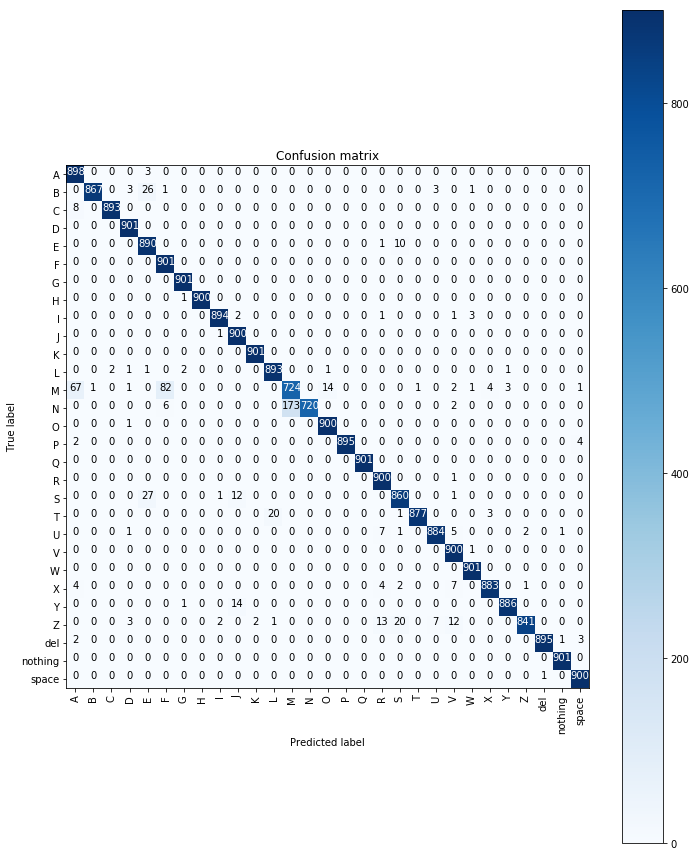

In [24]:
import sklearn
pred = np.argmax(res, axis = 1)
matrix = sklearn.metrics.confusion_matrix(validation_generator.classes, pred)
plot_confusion_matrix(matrix, classes, normalize=False)

In [33]:
predict_path = "/home/t-judai/kaggle-link/datasets/grassknoted/asl-alphabet/asl_alphabet_predict"
prediction_generator = train_datagen.flow_from_directory(
        predict_path,
        target_size=(224, 224),
        batch_size=24,
        class_mode='categorical',
        shuffle = False)   

Found 46992 images belonging to 29 classes.


164/164 [==============================] - 191s 1s/step
Confusion matrix, without normalization
[[ 61   0   0   0  13   4   0   0   2   0   0   0   0   0   0   0   0   1
   29   8   3   2   0   0   4   4   0   0   4]
 [  0 115   0   1   8   0   0   0   1   0   0   0   0   0   1   0   0   0
    0   2   2   0   0   1   0   2   0   0   2]
 [  0   0  85   8   1   6   0   0   0   0   0   0   0   0   8   0   0   1
    0   3   0   6   0   0   0  14   0   0   3]
 [  0   0   1 125   2   2   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   4   0   0   0   0   0   0   0]
 [  0   0   0   0 126   2   0   0   0   0   0   0   0   0   0   0   0   0
    1   3   1   1   0   1   0   0   0   0   0]
 [  2   0   0   1   3 120   0   0   1   0   0   1   0   3   0   0   0   0
    0   0   0   1   0   1   0   2   0   0   0]
 [  0   0   0   0   0   0  77  40   0   1   0   0   0   1   0   5   2   0
    0   1   0   1   0   0   0   1   0   0   6]
 [  0   0   1   0   0   1   2  92   0   0   0   0   0   1

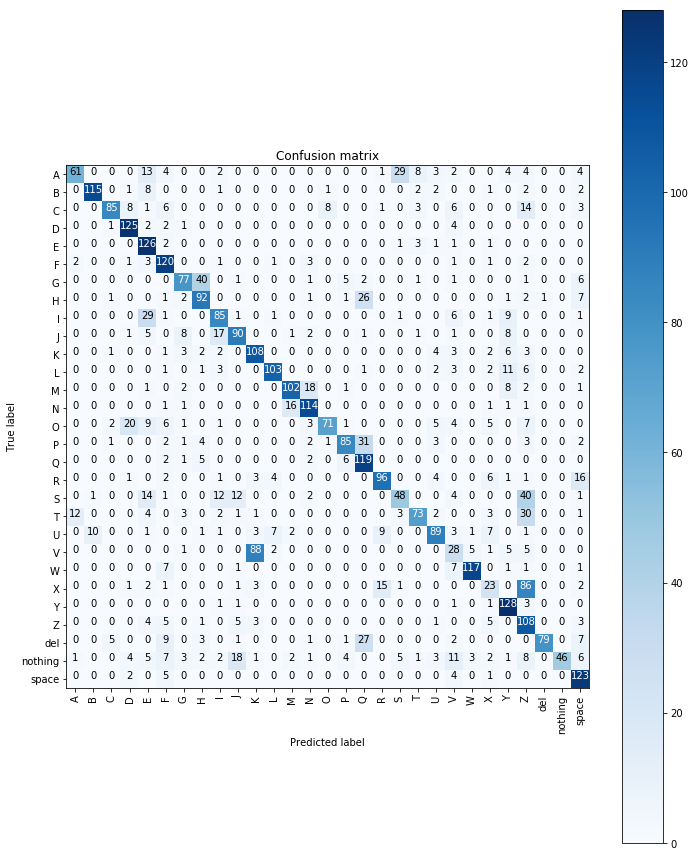

In [31]:
res = model.predict_generator(prediction_generator, verbose = 1)
pred = np.argmax(res, axis = 1)
matrix = sklearn.metrics.confusion_matrix(prediction_generator.classes, pred)
plot_confusion_matrix(matrix, classes, normalize=False)